# 뉴욕 택시 수요 예측
## 데이터 시각화 (2)
### 지역 관점으로 EDA
- 지역 별로는 어떻게 봐야할까?
    - 좌표는 달려있음
        - Reverse Geocoding : 위도/경도 => 주소로 변환
        - API를 날려야할까?
        - BigQuery GIS엔 shp 파일을 join해서 찾아내는 기능이 있음.

- Shp 파일
    - bigquery-public-data.geo_us_boundaries.zip_codes에 저장됨.
    - pickup_longitude, pickup_lattitutde가 zip_code_geom에 속하면 그 지역
- BigQuery GIS

In [1]:
import chart_studio.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
print(cf.__version__)

%config InlineBackend.figure_format ='retina'
cf.go_offline()

0.17.3


In [22]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입

In [2]:
%%time

query = """
WITH base_data AS(
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE EXTRACT(MONTH from pickup_datetime) = 1
    ), temp AS(
    SELECT nyc_taxi.*, gis.*
    FROM(
        SELECT *
        FROM base_data
        WHERE pickup_latitude <= 90 and pickup_latitude >= -90
        ) as nyc_taxi
    JOIN(
        SELECT zip_code, state_code, state_name, city, county, zip_code_geom
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE state_code='NY'
        ) as gis
        ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
        )
        
SELECT
    zip_code,
    city,
    ST_ASTEXT(zip_code_geom) as zip_code_geom,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', project_id='predictfornyctaxi')

CPU times: user 8.81 s, sys: 584 ms, total: 9.39 s
Wall time: 1min 55s


In [3]:
df.head(5)

,zip_code,city,zip_code_geom,pickup_hour,cnt
0,10029,New York city,"POLYGON((-73.955528 40.788245, -73.955778 40.7...",2015-01-01,204
1,11106,New York city,"POLYGON((-73.944715 40.762879, -73.944397 40.7...",2015-01-01,75
2,11378,New York city,"POLYGON((-73.935866 40.734345, -73.93742 40.73...",2015-01-01,1
3,10007,New York city,"POLYGON((-74.013382 40.714408, -74.0137 40.713...",2015-01-01,191
4,10154,New York city,"POLYGON((-73.973068 40.758432, -73.973524 40.7...",2015-01-01,12


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   zip_code       87020 non-null  object        
 1   city           87020 non-null  object        
 2   zip_code_geom  87020 non-null  object        
 3   pickup_hour    87020 non-null  datetime64[ns]
 4   cnt            87020 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.3+ MB


### Trip이 많은 zip_code는?

In [5]:
zip_code_agg_df = df.groupby(['zip_code', 'zip_code_geom'])[['cnt']].sum().reset_index()

In [6]:
zip_code_agg_df.head(5)

,zip_code,zip_code_geom,cnt
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454


In [8]:
zip_code_agg_df['percent'] = (zip_code_agg_df[['cnt']]/df[['cnt']].sum()).round(3).rename(columns={'cnt':'percent'}).reset_index()['percent']

In [9]:
zip_code_agg_df.head(5)

,zip_code,zip_code_geom,cnt,percent
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,0.051
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,0.019
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.005
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.004


- 위의 DF에서 percent는 전체 중 그 지역이 몇 % 비율을 차지하는지 나타냄.

In [10]:
zip_code_agg_df.tail(5)

,zip_code,zip_code_geom,cnt,percent
369,13656,"POLYGON((-76.067267 44.140696, -76.067236 44.1...",1,0.0
370,13691,"POLYGON((-75.88536 44.23349, -75.88501 44.2310...",1,0.0
371,14072,"MULTIPOLYGON(((-78.935536 42.965442, -78.93553...",1,0.0
372,14527,"MULTIPOLYGON(((-77.121905 42.624718, -77.12188...",1,0.0
373,14801,"POLYGON((-77.442016 42.140918, -77.44193 42.14...",1,0.0


- percent가 0인 것들 날리기

In [12]:
zip_code_agg_df['cnt'].sum()

12322300

In [13]:
filter_agg_df = zip_code_agg_df[zip_code_agg_df['percent'] > 0.000]

In [14]:
filter_agg_df['cnt'].sum()

12197865

In [15]:
filter_zip_code = filter_agg_df['zip_code'].to_list()

In [17]:
filter_agg_df.sort_values(by='cnt', ascending=False)

,zip_code,zip_code_geom,cnt,percent
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267,0.066
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,0.055
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,0.054
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053
...,...,...,...,...
194,11205,"POLYGON((-73.980649 40.701561, -73.980729 40.7...",8437,0.001
54,10167,"POLYGON((-73.975352 40.755303, -73.975807 40.7...",8186,0.001
45,10112,"POLYGON((-73.980426 40.759899, -73.980886 40.7...",8135,0.001
60,10173,"POLYGON((-73.979937 40.754783, -73.980395 40.7...",7966,0.001


In [20]:
filter_agg_df.to_csv('zip_code_ratio.csv', index=False)

### Kepler.gl에서 시각화

- 주소 : https://Kepler.gl

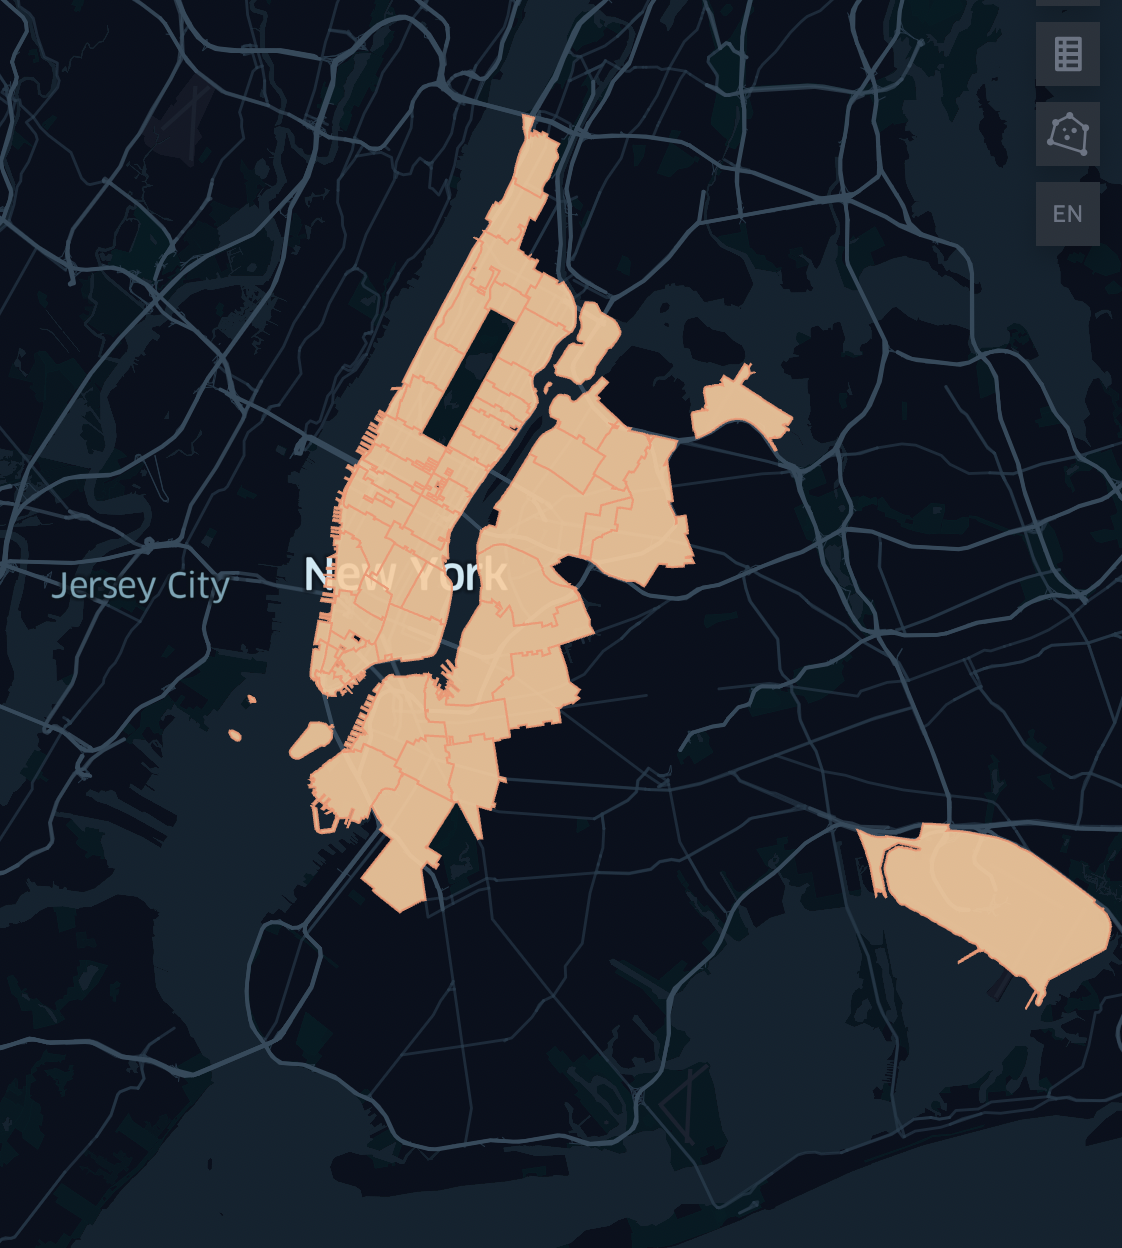

In [23]:
Image("data/original.png")

- 데이터를 Kepler에서 불러왔을 때 나오는 폴리곤
- 화면 가운데 빈 곳은 센트럴 파크이다.

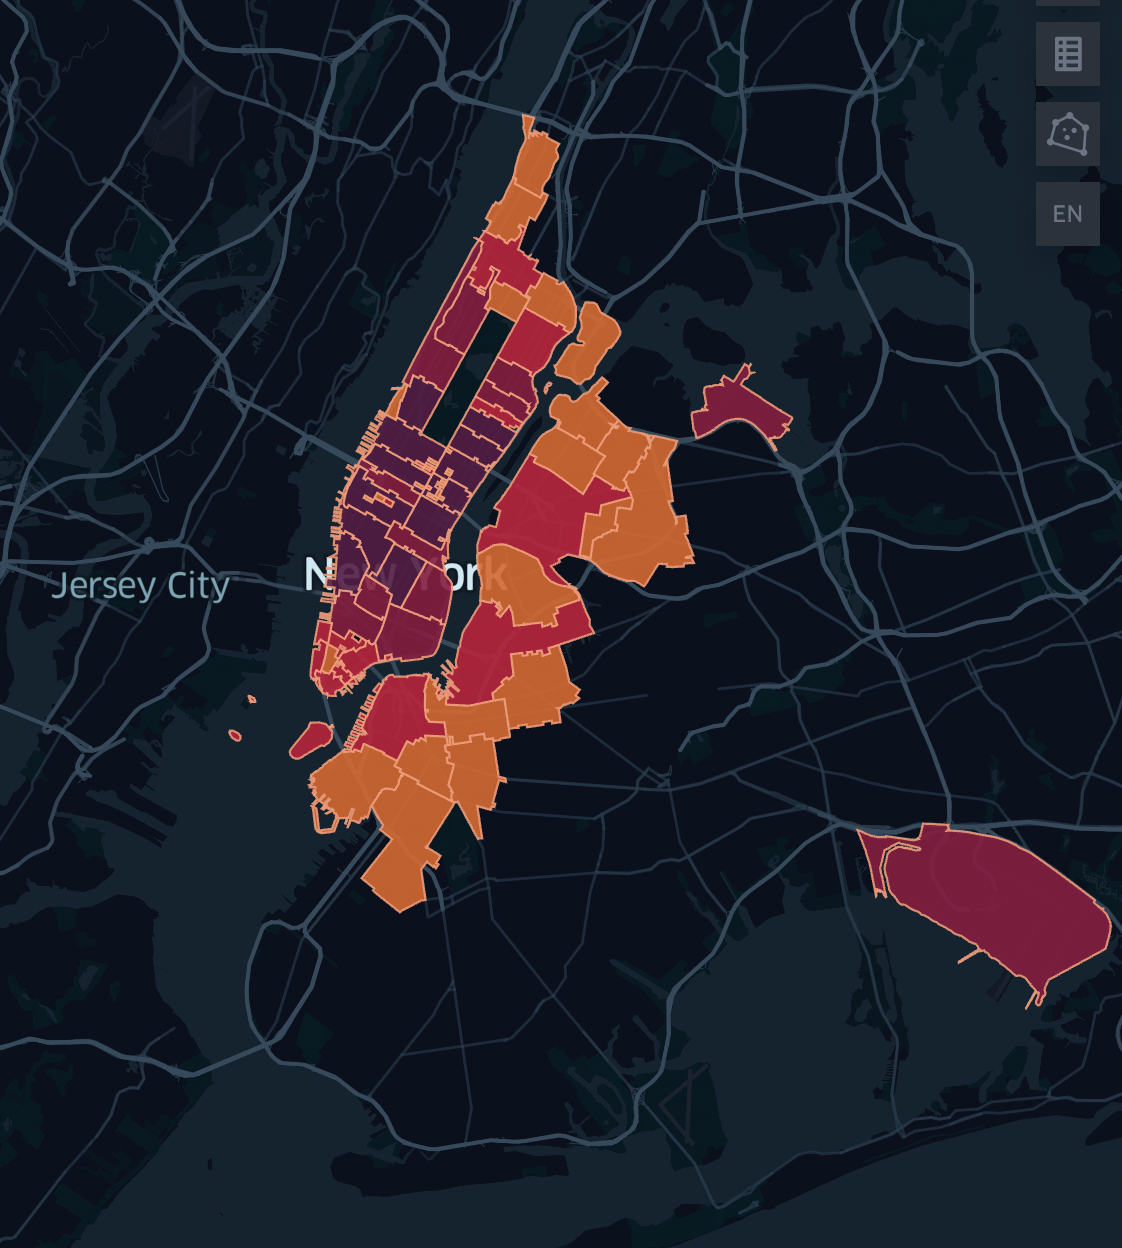

In [24]:
Image("data/color.png")

- 시간대 별로 어떻게 블록 별 소요가 높아지는지 확인 가능.

In [25]:
zip_df = df[['zip_code', 'zip_code_geom', 'pickup_hour', 'cnt']]

In [26]:
zip_df['date'] = zip_df['pickup_hour'].dt.date

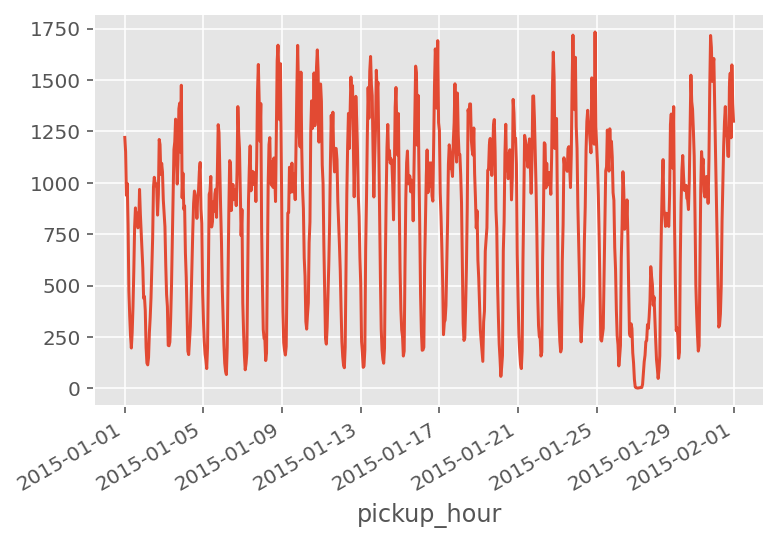

In [27]:
zip_df[zip_df['zip_code'] == '10001'].set_index('pickup_hour')['cnt'].plot();

### 하루 단위 zip_code 별 Trip Box Plot

In [29]:
filter_zip_df = zip_df[zip_df['zip_code'].isin(filter_zip_code)]

In [30]:
filter_zip_daily_df = filter_zip_df.groupby(['zip_code', 'date'])[['cnt']].sum().reset_index()

In [32]:
# cufflinks => 드래그로 가능
filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code').iplot(kind='box', x='zip_code')

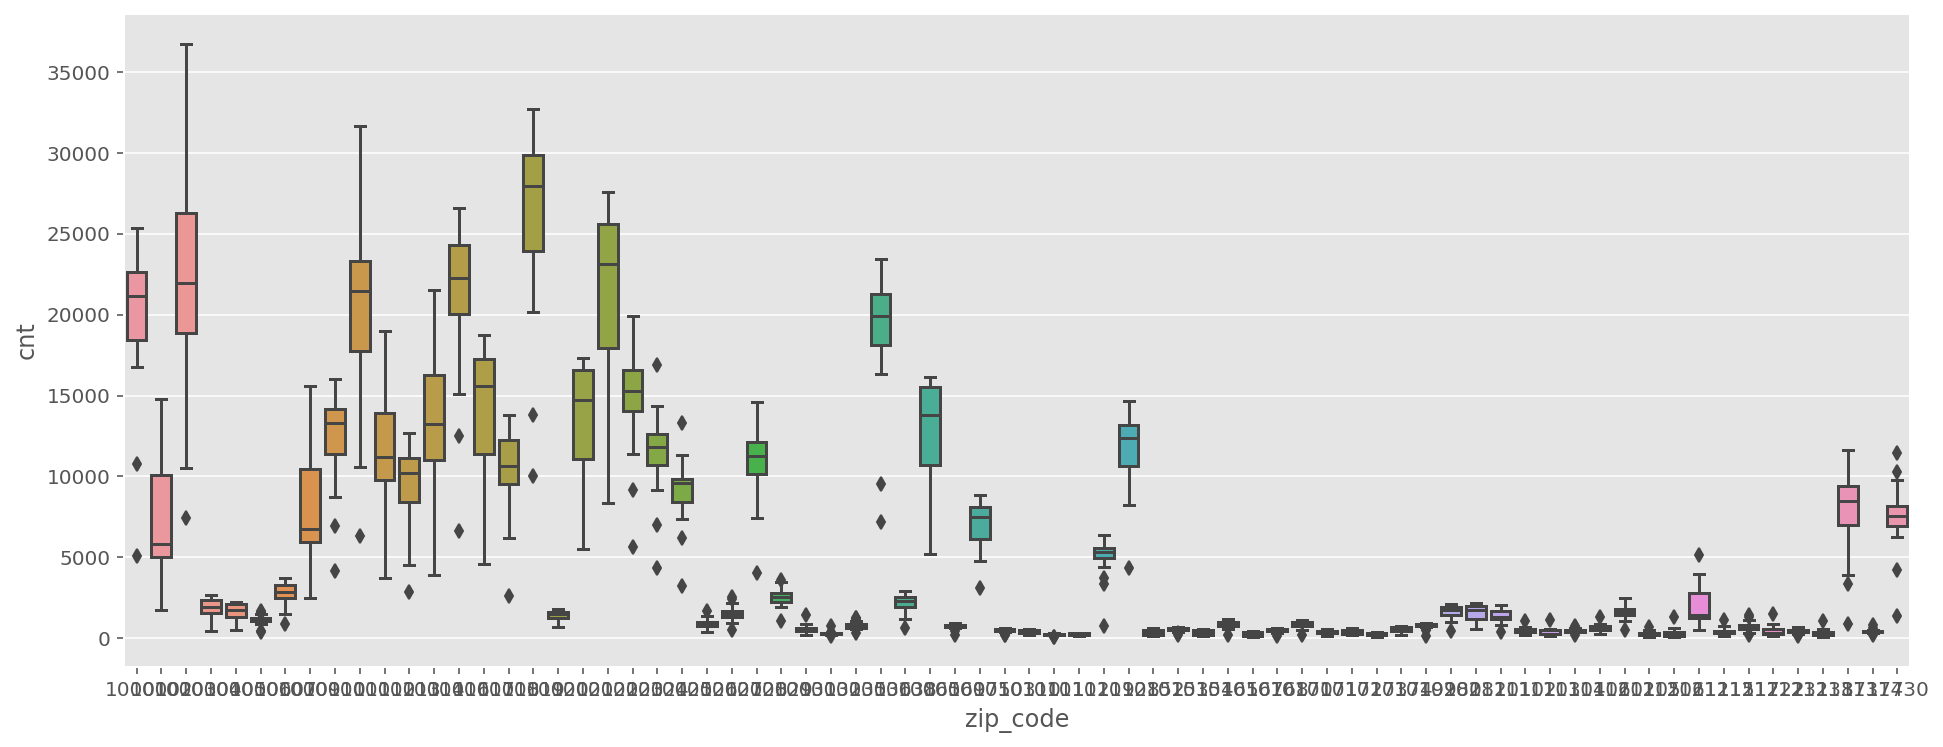

In [34]:
# seaborn
plt.figure(figsize=(16, 6));
sns.boxplot(x='zip_code', y='cnt', data=filter_zip_daily_df);

In [38]:
filter_zip_df[filter_zip_df['zip_code'] == '10001'][:5]

,zip_code,zip_code_geom,pickup_hour,cnt,date
42,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 00:00:00,1221,2015-01-01
248,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 01:00:00,1151,2015-01-01
440,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 02:00:00,939,2015-01-01
612,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 03:00:00,997,2015-01-01
781,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 04:00:00,794,2015-01-01


- zip_code 10001의 시간대 별로 몇 건이 Trip이 있었는지 알 수 있다.

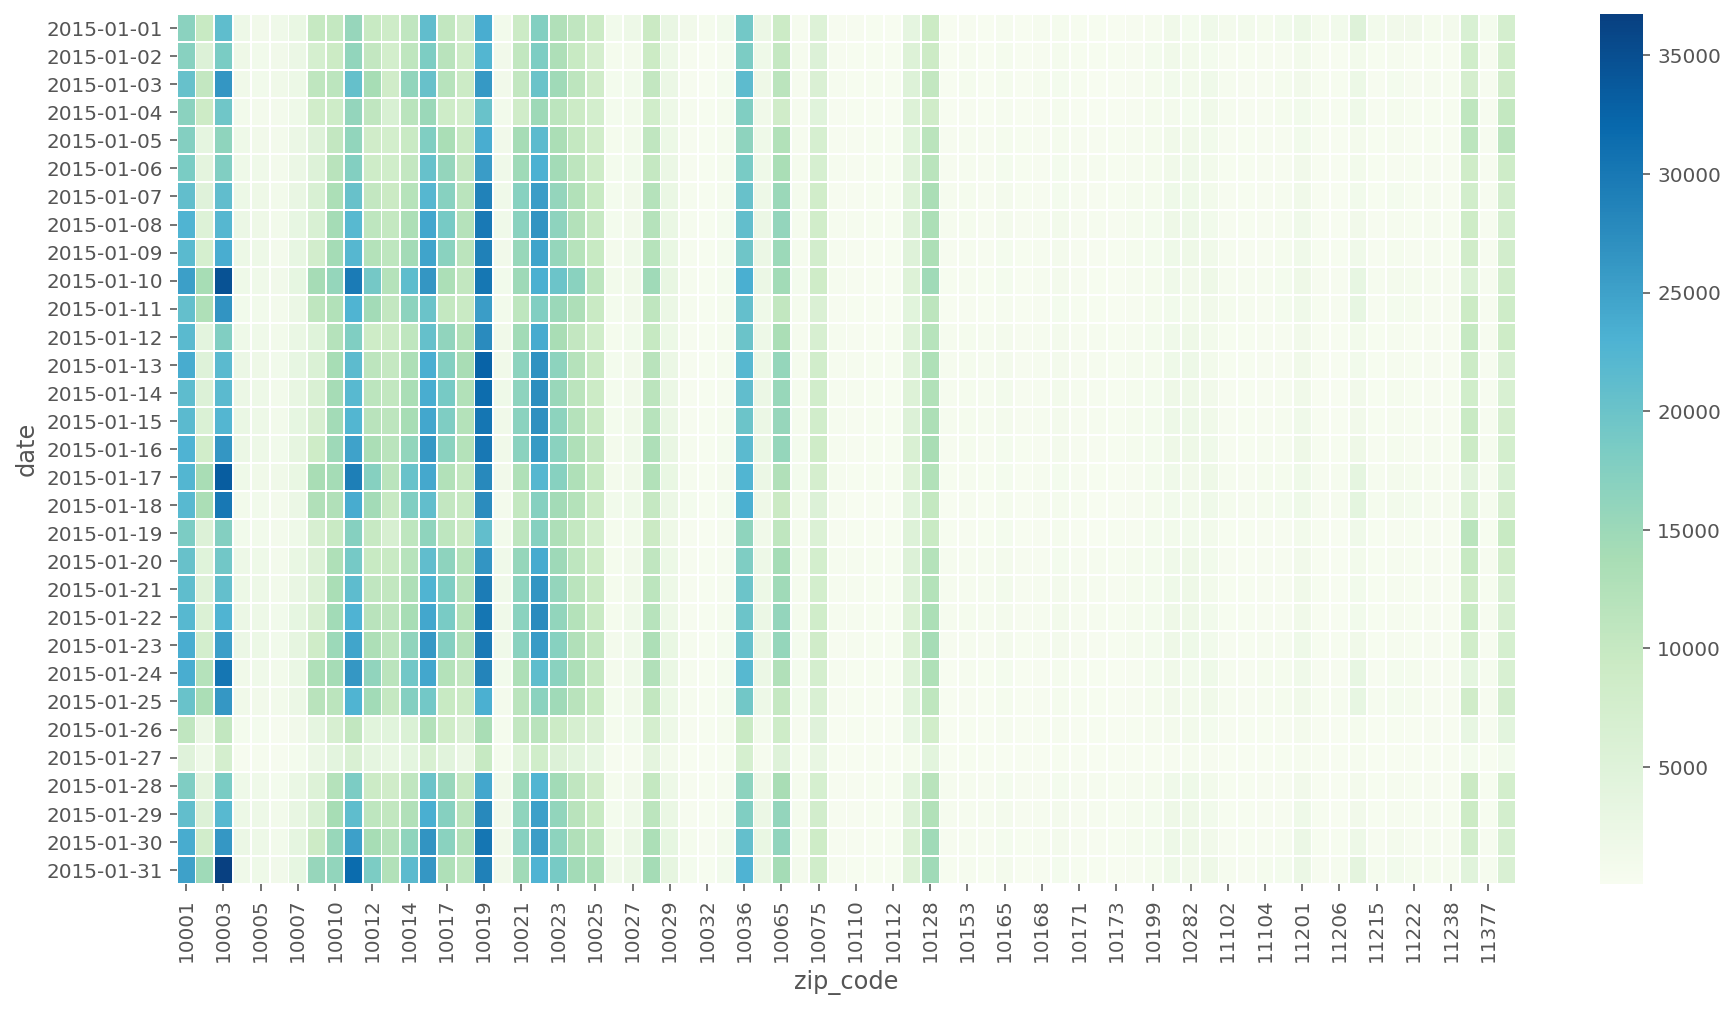

In [39]:
plt.figure(figsize=(15, 8))
sns.heatmap(filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code'),
           lw=.5, cmap='GnBu');

- 항상 진한 부분이 나타나는 것으로 미루어보았을 때,
- 어느 정도 주기성을 띈다.

### Zip code의 시간대 별 추이

In [40]:
filter_zip_df['hour'] = filter_zip_df['pickup_hour'].dt.hour

In [41]:
filter_zip_df.head(3)

,zip_code,zip_code_geom,pickup_hour,cnt,date,hour
0,10029,"POLYGON((-73.955528 40.788245, -73.955778 40.7...",2015-01-01,204,2015-01-01,0
1,11106,"POLYGON((-73.944715 40.762879, -73.944397 40.7...",2015-01-01,75,2015-01-01,0
3,10007,"POLYGON((-74.013382 40.714408, -74.0137 40.713...",2015-01-01,191,2015-01-01,0


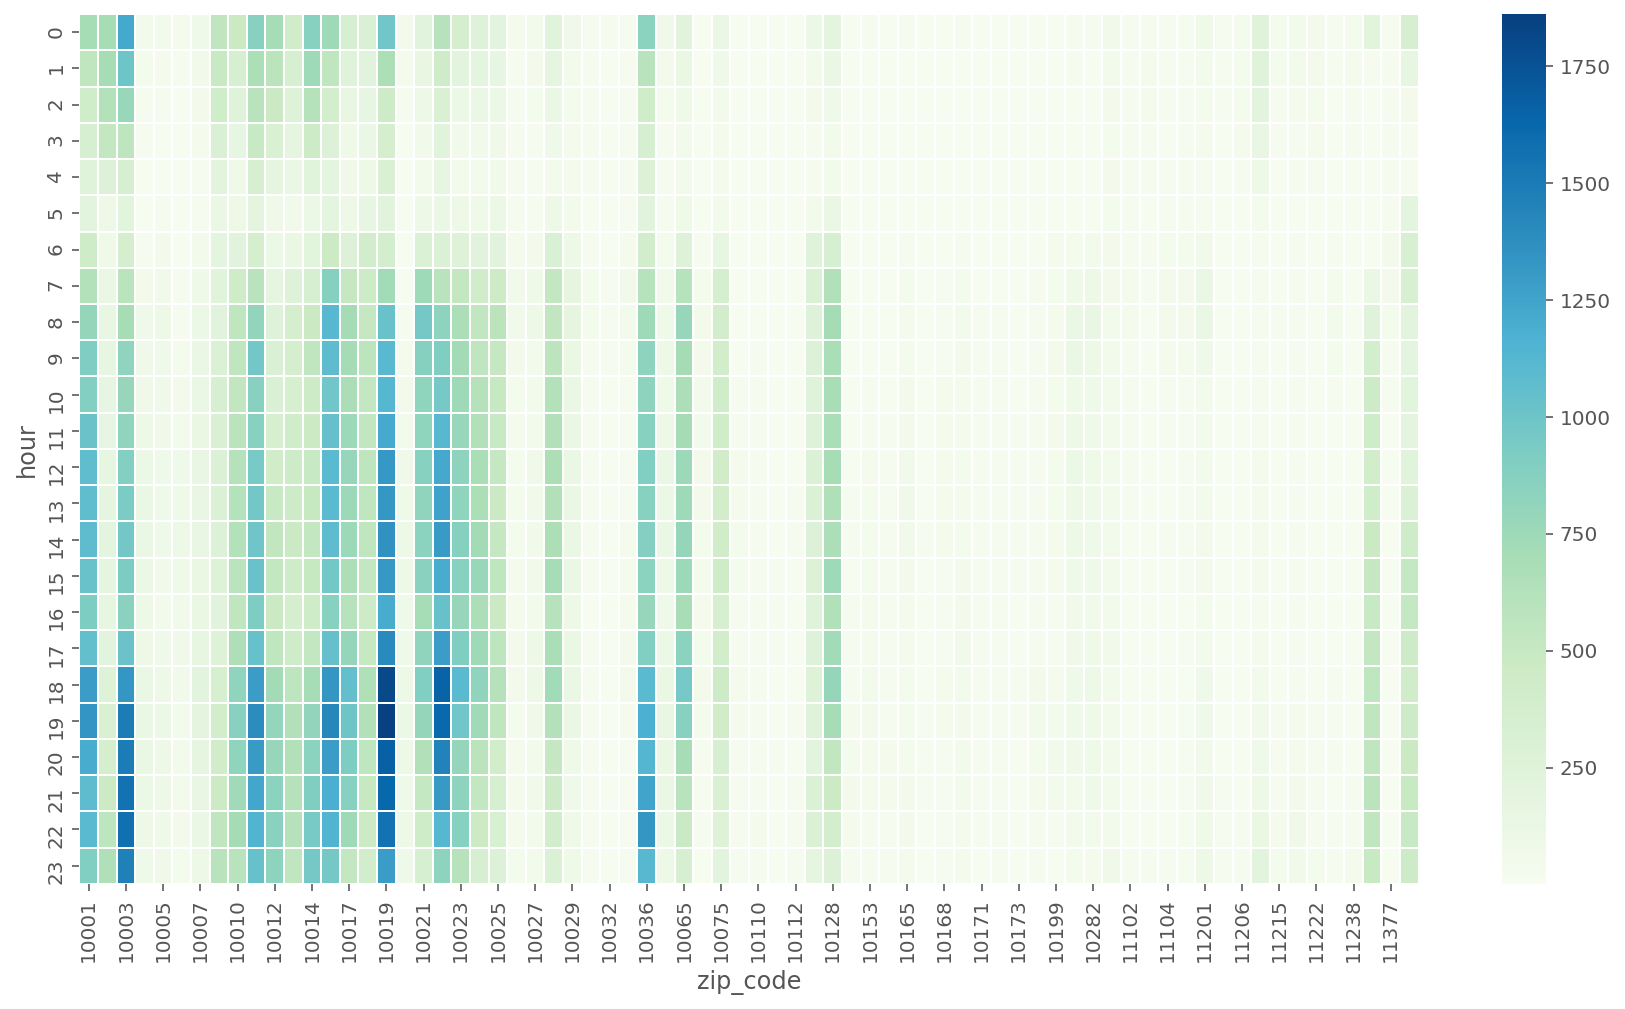

In [43]:
plt.figure(figsize=(15, 8))
sns.heatmap(filter_zip_df.pivot_table('cnt', index='hour', columns='zip_code', aggfunc='mean'),
           lw=.5, cmap='GnBu');

- 10001은 시간대 별로 18~19시 (아마 퇴근시간?)에 오르고,
- 10003은 18시부터 계속해서 오른다.
- 10019도 10003과 똑같은 양상을 보이는데 패턴을 보았을 때,
- 비슷한 지역이라고 볼 수 있다.